In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from datasets import Dataset, DatasetDict, Image as HFDatasetImage
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
import albumentations as A
np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

In [2]:
# Path to the director where images for semantic segmentation are stored
IMAGES_DIR = 'data/Image/'
# Path to the directory where labels for semantic segmentation are stored
LABELS_DIR = 'data/Mask/'
IMG_EXT = 'jpg'
LABEL_EXT = 'png'

In [3]:
metadata = pd.read_csv('data/metadata.csv')
metadata.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [4]:
def get_all_images_labels(IMAGES_DIR, LABELS_DIR, metadata):
    """
    Return the list of all valid images and labels
    """
    images = []
    labels = []
    min_h = 1e6; max_h = 0
    min_w = 1e6; max_w = 0
    for _, row in metadata.iterrows():
        image = os.path.join(IMAGES_DIR, row['Image'])
        label = os.path.join(LABELS_DIR, row['Mask'])
        img_arr = np.array(Image.open(image))
        label_arr = np.array(Image.open(label))
        if (img_arr.ndim == 3) and (img_arr.shape[2] == 3) and (img_arr.shape[:-1] == label_arr.shape):
            min_h = min(min_h, img_arr.shape[0]); max_h = max(max_h, img_arr.shape[0])
            min_w = min(min_w, img_arr.shape[1]); max_w = max(max_w, img_arr.shape[1])
            images.append(image)
            labels.append(label)
        else:
            print(f"Skipping image {row['Image']} and mask {row['Mask']}")
    print(f"Min height: {min_h}, Max height: {max_h}")
    print(f"Min width: {min_w}, Max width: {max_w}")
    return images, labels

In [5]:
# Take the first TRAIN_SIZE images for training
all_images, all_labels = get_all_images_labels(IMAGES_DIR, LABELS_DIR, metadata)

print(len(all_images), len(all_labels))
print(all_images[:5])
print(all_labels[:5])

Skipping image 0.jpg and mask 0.png
Skipping image 2.jpg and mask 2.png
Skipping image 14.jpg and mask 14.png
Skipping image 15.jpg and mask 15.png
Skipping image 2052.jpg and mask 2052.png
Skipping image 2053.jpg and mask 2053.png
Skipping image 3048.jpg and mask 3048.png
Skipping image 3059.jpg and mask 3059.png
Skipping image 1061.jpg and mask 1061.png
Skipping image 1079.jpg and mask 1079.png
Min height: 219, Max height: 3648
Min width: 330, Max width: 5472
280 280
['data/Image/1.jpg', 'data/Image/3.jpg', 'data/Image/4.jpg', 'data/Image/5.jpg', 'data/Image/6.jpg']
['data/Mask/1.png', 'data/Mask/3.png', 'data/Mask/4.png', 'data/Mask/5.png', 'data/Mask/6.png']


In [6]:
TRAIN_SIZE = 200 # Number of images to use for training
VAL_SIZE = 20 # Number of images to use for validation
TEST_SIZE = 60 # Number of images to use for testing

In [7]:
image_paths_train = all_images[:TRAIN_SIZE]
label_paths_train = all_labels[:TRAIN_SIZE]

print(image_paths_train[:5])
print(label_paths_train[:5])

image_paths_val = all_images[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
label_paths_val = all_labels[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

print(image_paths_val[:5])
print(label_paths_val[:5])

image_paths_test = all_images[-TEST_SIZE:]
label_paths_test = all_labels[-TEST_SIZE:]

print(image_paths_test[:5])
print(label_paths_test[:5])

['data/Image/1.jpg', 'data/Image/3.jpg', 'data/Image/4.jpg', 'data/Image/5.jpg', 'data/Image/6.jpg']
['data/Mask/1.png', 'data/Mask/3.png', 'data/Mask/4.png', 'data/Mask/5.png', 'data/Mask/6.png']
['data/Image/1006.jpg', 'data/Image/1007.jpg', 'data/Image/1008.jpg', 'data/Image/1009.jpg', 'data/Image/1010.jpg']
['data/Mask/1006.png', 'data/Mask/1007.png', 'data/Mask/1008.png', 'data/Mask/1009.png', 'data/Mask/1010.png']
['data/Image/1026.jpg', 'data/Image/1027.jpg', 'data/Image/1028.jpg', 'data/Image/1029.jpg', 'data/Image/1030.jpg']
['data/Mask/1026.png', 'data/Mask/1027.png', 'data/Mask/1028.png', 'data/Mask/1029.png', 'data/Mask/1030.png']


In [8]:
def convert_to_binary_mask(label_path, threshold=128):
    """
    Convert a label image to a binary mask using a threshold
    """
    # Load the label image as a numpy array
    label_image = np.array(Image.open(label_path))
    
    # Apply thresholding to create a binary mask (values >= threshold will be 2, others 1)
    binary_mask = (label_image >= threshold).astype(np.uint8)
    
    return binary_mask

def create_dataset(image_paths, label_paths, threshold=128):
    # Create Dataset from image paths and label paths
    dataset = Dataset.from_dict({"image": image_paths,
                                 "label": [convert_to_binary_mask(label_path, threshold) for label_path in label_paths]})
    
    # Cast the "image" column to use the HFDatasetImage class to handle image loading
    dataset = dataset.cast_column("image", HFDatasetImage())

    # dataset = dataset.cast_column("label", HFDatasetImage())
    
    return dataset

train_dataset = create_dataset(image_paths_train, label_paths_train)
val_dataset = create_dataset(image_paths_val, label_paths_val)
test_dataset = create_dataset(image_paths_test, label_paths_test)

In [9]:
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
  }
)

In [10]:
train_ds = dataset["train"]
val_ds = dataset["val"]
test_ds = dataset["test"]

In [11]:
idx = 5
example = dataset["train"][idx]
image = example["image"]
print(np.array(image).shape)

(1500, 2000, 3)


In [12]:
# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])
segmentation_map, segmentation_map.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (1500, 2000))

In [13]:
np.unique(segmentation_map)

array([0, 1])

In [14]:
# Define the mapping from pixel values to class labels
id2label = {0: 'other', 1: 'flood'}

In [15]:
# Assign green color to non-flood and red color to flood
palette = np.array([[0, 255, 0], [0, 0, 255]])

In [16]:
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

In [17]:
class ImageSegmentationDataset(TorchDataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [18]:
def compute_stats(dataset):
    """
    Calculate mean and standard deviation of each channel of the images in the dataset
    """
    mean = []
    std = []
    for i in tqdm(range(len(dataset))):
        image = np.array(dataset[i]['image'])
        mean.append([float(image[:, :, i].mean()) for i in range(image.shape[2])])
        std.append([float(image[:, :, i].std()) for i in range(image.shape[2])])
        
    mean = np.array(mean).mean(axis=0)
    std = np.array(std).mean(axis=0)
    return mean, std

mean, std = compute_stats(train_ds)
mean, std

100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


(array([127.61284707, 126.67704506, 114.08192164]),
 array([55.01579928, 49.45631369, 53.15144932]))

In [19]:
FLOOD_MEAN = mean / 255
FLOOD_STD = std / 255

H = 512
W = 512

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=5000),
    A.Resize(width=768, height=768),
    A.RandomCrop(width=W, height=H),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=tuple(FLOOD_MEAN), std=tuple(FLOOD_STD)),
])

test_transform = A.Compose([
    A.Resize(width=W, height=H),
    A.Normalize(mean=tuple(FLOOD_MEAN), std=tuple(FLOOD_STD)),
])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
val_dataset = ImageSegmentationDataset(val_ds, transform=test_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [20]:
image, segmentation_map, _, _ = train_dataset[5]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


In [21]:
image.min(), image.max(), segmentation_map.min(), segmentation_map.max()

(-2.3794138, 2.6512556, 0, 1)

In [22]:
unnormalized_image = (image * np.array(FLOOD_STD)[:, None, None]) + np.array(FLOOD_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

In [23]:
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

In [24]:
from transformers import MaskFormerImageProcessor
preprocessor = MaskFormerImageProcessor(ignore_index=-1,reduce_labels=False, do_resize=False,
                                        do_rescale=False, do_normalize=False, num_labels=2)

2024-11-27 17:10:27.889156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 17:10:27.890778: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 17:10:27.922696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 17:10:28.752203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
BATCH_SIZE = 4

In [26]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
mask_labels torch.Size([2, 512, 512])
class_labels torch.Size([2])
original_images (244, 330, 3)
original_segmentation_maps (244, 330)


In [28]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 512, 512)

In [29]:
unnormalized_image = (pixel_values * np.array(FLOOD_STD)[:, None, None]) + np.array(FLOOD_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

In [30]:
batch["class_labels"][0].tolist()

[0, 1]

In [31]:
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['other', 'flood']


In [32]:
def visualize_mask(labels, label_name):
  """
  Visualize the mask for a specific label
  """
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: flood


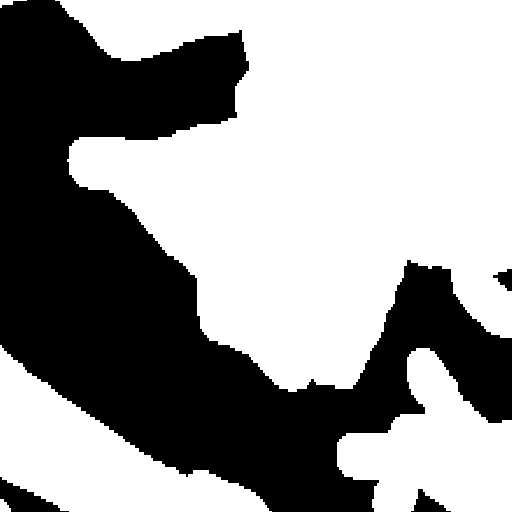

In [33]:
visualize_mask(labels, "flood")

In [34]:
# Define the model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt

In [36]:
if torch.cuda.is_available():
       device = torch.device('cuda')
       print("GPU is available and being used.")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU instead.")
# device = torch.device('cpu')

GPU is available and being used.


In [37]:
import torch
from torch_geometric.data import Data, Batch

L_CLOSEST = 8  # Number of closest nodes to connect in distance-based edges
SIGMA = 0.5  # Used in Gaussian function for distance-based edges

# Gaussian kernel function to compute edge weight based on Euclidean distance
def weight_gauss(node_i, node_j, sigma=SIGMA):
    dist = torch.norm(node_i - node_j, p=2, dim=-1)
    return torch.exp(-dist / sigma)

def initialize_graph(fcn_output, num_neighbors=L_CLOSEST):
    """
    Initialize nodes and edges for the graph based on FCN output.
    Args:
        fcn_output (torch.Tensor): Output from the FCN model, shape [batch_size, channels, height, width].
        num_neighbors (int): Number of nearest neighbors to connect each node.
    Returns:
        Data: PyTorch Geometric graph object with initialized nodes and edges.
    """
    device = fcn_output.device  # Get the device of the input tensor
    batch_size, channels, height, width = fcn_output.shape
    num_nodes = height * width

    # Flatten the feature map to create nodes
    node_features = fcn_output.view(batch_size, channels, -1).permute(0, 2, 1).to(device)  # [batch_size, num_nodes, channels]

    # Create a grid of node indices
    node_indices = torch.arange(num_nodes, device=device).view(1, height, width).repeat(batch_size, 1, 1)

    # Compute the spatial coordinates of each node
    x = node_indices % width
    y = node_indices // width

    # Normalize the coordinates to be in the range [-1, 1]
    x = 2 * (x.float() / (width - 1)) - 1
    y = 2 * (y.float() / (height - 1)) - 1

    # Concatenate the coordinates with the node features
    node_features = torch.cat([node_features, x.reshape(batch_size, -1, 1), y.reshape(batch_size, -1, 1)], dim=-1)

    # Take num_neighbors nearest neighbors using the Euclidean distance
    graphs = []
    for i in range(batch_size):
        # Compute pairwise distances between nodes
        dist = torch.cdist(node_features[i], node_features[i], p=2)

        # Get the indices of the k nearest neighbors for each node
        _, indices = torch.topk(dist, num_neighbors + 1, largest=False, sorted=False)

        # Create edges between each node and its k nearest neighbors
        edge_index = []
        edge_weight = []
        for j in range(num_nodes):
            edge_index.extend([(j, k) for k in indices[j, 1:]])
            edge_weight.extend([weight_gauss(node_features[i, j], node_features[i, k]) for k in indices[j, 1:]])
        edge_index = torch.tensor(edge_index, dtype=torch.long, device=device).t().contiguous()
        edge_weight = torch.tensor(edge_weight, dtype=torch.float, device=device)

        graphs.append(Data(x=node_features[i], edge_index=edge_index, edge_attr=edge_weight))

    graphs = Batch.from_data_list(graphs)

    return graphs

In [38]:
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return F.log_softmax(x, dim=1)

In [39]:
import torch
import torch.nn.functional as F

def get_feature_map_labels(ground_truth, feature_map_size):
    """
    Downsamples the ground truth to match the size of the feature map for node-level labeling,
    accommodating batch inputs.

    Parameters:
    - ground_truth: Tensor of shape (batch_size, H, W), with pixel-level labels for each image in the batch.
    - feature_map_size: Tuple (h, w), the size of the feature map.
    - device: The device to move tensors to (e.g., 'cuda' or 'cpu').

    Returns:
    - Tensor of shape (batch_size, h, w), with the downsampled labels for each node in the feature map.
    """
    # Ensure ground_truth tensor has shape (batch_size, 1, H, W) for resizing
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth.unsqueeze(1)  # Adds channel dimension

    # Move ground_truth to the specified device
    ground_truth = ground_truth.to(device)

    # Resize the ground truth to the feature map size using nearest-neighbor interpolation
    # This keeps the most frequent (dominant) label in each region.
    downsampled_labels = F.interpolate(
        ground_truth.float(),  # Already has batch and channel dimensions
        size=feature_map_size,  # Resize to feature map size
        mode='nearest'  # Nearest-neighbor interpolation to preserve labels
    ).squeeze(1).long()  # Remove channel dimension

    return downsampled_labels

# Assume ground truth mask batch is of shape (batch_size, H, W)
batch_size = 4
ground_truth = torch.randint(0, 21, (batch_size, 512, 512))  # Sample ground truth with 21 classes, shape (batch_size, H, W)
feature_map_size = (32, 32)  # Target feature map size

# Get the downsampled ground truth for feature map nodes
node_labels = get_feature_map_labels(ground_truth, feature_map_size)

print(node_labels.shape)  # Should be (batch_size, 32, 32)

torch.Size([4, 32, 32])


In [40]:
# Create a function to hook into the forward pass to get ASPP output
def get_aspp_output(model, input_img):
    # Ensure the model and input are on the correct device
    model.to(device)
    input_img = input_img.to(device)

    # Hook into the model to get the output after the ASPP module
    def hook_fn(module, input, output):
        hook_fn.output = output
    
    # Register the hook
    hook = model.classifier[-1].register_forward_hook(hook_fn)

    with torch.no_grad():
        # Perform a forward pass
        model(input_img)

    # Remove the hook
    hook.remove()

    return hook_fn.output

In [41]:
class GraphFCN(nn.Module):
    def __init__(self, deeplab_model, gcn_model):
    # def __init__(self, gcn_model):
        super(GraphFCN, self).__init__()
        self.fcn = deeplab_model  # Pretrained or custom FCN model
        self.gcn = gcn_model  # GCN model initialized with SimpleGCN class

    def forward(self, x):
        # Ensure the model and input are on the correct device
        self.fcn.to(device)
        self.gcn.to(device)

        # Step 1: Use FCN to initialize graph node features
        fcn_output = get_aspp_output(self.fcn, x)

        # Step 2: Initialize graph nodes and edges
        graph = initialize_graph(fcn_output, 3)
        
        # Step 3: Apply GCN to the graph
        outputs = []
        for i in range(graph.num_graphs):
            output = self.gcn(graph[i].x, graph[i].edge_index, graph[i].edge_attr)
            outputs.append(output)
        output = torch.cat(outputs, dim=0)

        # FCN segmentation output
        fcn_seg = self.fcn(x)
        fcn_seg = fcn_seg['out']
        
        f_map_s1 = fcn_output.shape[2]
        f_map_s2 = fcn_output.shape[3]

        return fcn_seg, output, f_map_s1, f_map_s2
        # return output

In [63]:
def calculate_final_loss(input_img, ground_truth, device):
    """
    Calculate the final loss for the GraphFCN model.

    Parameters:
    - graph_fcn: GraphFCN model instance.
    - input_img: Input image tensor of shape (C, H, W).
    - ground_truth: Ground truth tensor of shape (H, W).
    - device: The device to move tensors to (e.g., 'cuda' or 'cpu').

    Returns:
    - loss: Final loss value.
    """
    
    global graph_fcn
    
    # Ensure the model and input are on the correct device
    graph_fcn.to(device)
    input_img = input_img.to(device)
    ground_truth = ground_truth.to(device)

    # Forward pass through the model
    fcn_output, gcn_output, f_map_s1, f_map_s2 = graph_fcn(input_img)

    # Calculate pixel-wise cross-entropy loss using FCN output
    criterion = nn.CrossEntropyLoss()
    
    fcn_loss = criterion(fcn_output, ground_truth)

    # Calculate node-wise cross-entropy loss using GCN output
    node_labels = get_feature_map_labels(ground_truth, [f_map_s1, f_map_s2])

    gcn_loss = criterion(gcn_output, node_labels.view(-1))

    # Combine the losses
    loss = gcn_loss + fcn_loss

    return loss


In [43]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

In [44]:
def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head

    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
        device: The device to move the model to (e.g., 'cuda' or 'cpu').

    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    # Initialize the DeepLabV3 model with a ResNet101 backbone
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)  # Replace the classifier head

    # Move the model to the specified device (GPU or CPU)
    if device:
        model = model.to(device)

    # Set the model in training mode
    model.train()

    return model


In [45]:
def get_mask(labels, label_name, batch, pos):
  idx = labels.index(label_name)
  visual_mask = (batch["mask_labels"][pos][idx].bool().numpy()).astype(np.uint8)
  return visual_mask

In [46]:
import evaluate

metric = evaluate.load("mean_iou")

In [56]:
# final output is the output of the deep lab model
def evaluate_iou(dataloader, metric: evaluate.EvaluationModule):
    global graph_fcn
    graph_fcn.eval()
    for _, batch in enumerate(tqdm(dataloader)):
        inputs = batch['pixel_values']
        inputs = inputs.to(device)
        labels = batch['class_labels']
        masks = []
        for j, obj in enumerate(labels):
            temp_labels = [id2label[label] for label in obj.tolist()]
            temp_mask = get_mask(temp_labels, "flood", batch, j)
            masks.append(temp_mask) 
        masks = np.array(masks)
        masks = torch.tensor(masks).long().to(device)
        with torch.no_grad():
            fcn_output, _, _, _ = graph_fcn(inputs)
            fcn_output = fcn_output.argmax(dim=1)
            metric.add_batch(
                predictions=fcn_output,
                references=masks
            )
    return metric.compute(num_labels = len(id2label), ignore_index = -1)

In [48]:
deeplab = createDeepLabv3(2)
deeplab.train()
gcn = SimpleGCN(in_channels=4, hidden_channels=64, out_channels=2).to(device)
graph_fcn = GraphFCN(deeplab, gcn).to(device)

/home/co21btech11002/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/co21btech11002/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
def calc_total_loss(loader):
    total_loss = 0
    for i, batch in enumerate(loader):
        inputs = batch['pixel_values']
        labels = batch['class_labels']
        masks = []
        for j, obj in enumerate(labels):
            temp_labels = [id2label[label] for label in obj.tolist()]
            temp_mask = get_mask(temp_labels, "flood", batch, j)
            masks.append(temp_mask) 
        masks = np.array(masks)
        masks = torch.tensor(masks).long().to(device)
        loss = calculate_final_loss(inputs, masks, device)
        total_loss += loss.item()
        del inputs, labels, masks, loss
    return total_loss

In [50]:
import torch.optim as optim

optimizer = optim.Adam(graph_fcn.parameters(), lr=0.0001)

def train_model(train_dataloader, num_epochs=5):
    """
    Train the GraphFCN model.

    Parameters:
    - train_dataloader: Training DataLoader instance.
    - num_epochs: Number of epochs to train the model.
    """
    global graph_fcn
    
    # Move the model to the specified device
    graph_fcn.to(device)

    # Set the model in training mode
    graph_fcn.train()

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        running_loss = 0.0

        # Iterate over the training dataset
        for i, data in enumerate(train_dataloader):
            try:
                # Get the inputs and labels
                inputs = data['pixel_values']
                inputs = inputs.to(device)
                
                labels = data['class_labels']
                masks = []
                for j, obj in enumerate(labels):
                    temp_labels = [id2label[label] for label in obj.tolist()]
                    temp_mask = get_mask(temp_labels, "flood", data, j)
                    masks.append(temp_mask) 
                masks = np.array(masks)
                masks = torch.tensor(masks).long().to(device)
                            
                optimizer.zero_grad()

                loss = calculate_final_loss(graph_fcn, inputs, masks, device)
                
                loss.backward()
                optimizer.step()
                
                # Print statistics
                running_loss += loss.item()
                if i % 10 == 9:
                    print(f"Batch {i + 1}, Loss: {running_loss / 10}")
                    running_loss = 0.0
            except Exception as e:
                print("Epoch: ", epoch, "Batch: ", i, "Error: ", e)
                
        torch.save(graph_fcn.state_dict(), f"graph_fcn_epoch_{epoch}.pth")

    print("Finished Training")

In [51]:
train_model(train_dataloader, num_epochs=60)

Epoch 1
-------------------------------
Batch 10, Loss: 1.2705750823020936
Batch 20, Loss: 1.0106820523738862
Batch 30, Loss: 1.0232680499553681
Batch 40, Loss: 0.9028593599796295
Batch 50, Loss: 0.9690588772296905
Epoch 2
-------------------------------
Batch 10, Loss: 0.8523007869720459
Batch 20, Loss: 0.813242381811142
Batch 30, Loss: 0.8067574322223663
Batch 40, Loss: 0.7697293579578399
Batch 50, Loss: 0.6997232913970948
Epoch 3
-------------------------------
Batch 10, Loss: 0.7299722552299499
Batch 20, Loss: 0.7027231633663178
Batch 30, Loss: 0.7487381041049957
Batch 40, Loss: 0.6649606108665467
Batch 50, Loss: 0.7099099338054657
Epoch 4
-------------------------------
Batch 10, Loss: 0.6060886979103088
Batch 20, Loss: 0.6226812660694122
Batch 30, Loss: 0.5492089420557023
Batch 40, Loss: 0.5746367335319519
Batch 50, Loss: 0.5698561817407608
Epoch 5
-------------------------------
Batch 10, Loss: 0.5113620519638061
Batch 20, Loss: 0.5111570298671723
Batch 30, Loss: 0.5033069312572

In [52]:
torch.save(graph_fcn.state_dict(), 'trained/graph_fcn.pth')

In [57]:
evaluate_iou(train_dataloader, metric)

  0%|          | 0/50 [00:00<?, ?it/s]/home/co21btech11002/.local/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
100%|██████████| 50/50 [07:43<00:00,  9.26s/it]


{'mean_iou': 0.9346972008057319,
 'mean_accuracy': 0.966508821167699,
 'overall_accuracy': 0.9667852783203125,
 'per_category_iou': array([0.94281394, 0.92658046]),
 'per_category_accuracy': array([0.96862429, 0.96439335])}

In [58]:
evaluate_iou(val_dataloader, metric)

100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


{'mean_iou': 0.8394972050552776,
 'mean_accuracy': 0.9143988243253294,
 'overall_accuracy': 0.9134284973144531,
 'per_category_iou': array([0.8531114 , 0.82588301]),
 'per_category_accuracy': array([0.90561003, 0.92318762])}

In [59]:
evaluate_iou(test_dataloader, metric)

100%|██████████| 15/15 [01:59<00:00,  7.99s/it]


{'mean_iou': 0.8345509737122104,
 'mean_accuracy': 0.9088587527043563,
 'overall_accuracy': 0.9183301289876302,
 'per_category_iou': array([0.88343263, 0.78566932]),
 'per_category_accuracy': array([0.93855405, 0.87916345])}

In [60]:
# visualize the output of the model
def visualize_output(model, dataloader, num_images=2):
    # model.eval()
    for i, batch in enumerate(dataloader):
        if i >= num_images:
            break
        inputs = batch['pixel_values']
        inputs = inputs.to(device)
        labels = batch['class_labels']
        masks = []
        for j, obj in enumerate(labels):
            temp_labels = [id2label[label] for label in obj.tolist()]
            temp_mask = get_mask(temp_labels, "flood", batch, j)
            masks.append(temp_mask) 
        masks = np.array(masks)
        masks = torch.tensor(masks).long().to(device)
        with torch.no_grad():
            fcn_output, _, _, _ = model(inputs)
            fcn_output = fcn_output.argmax(dim=1)
            fcn_output = fcn_output.cpu().numpy()
            masks = masks.cpu().numpy()
            for j in range(inputs.shape[0]):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                inp_temp = inputs[j].cpu()
                plt.imshow(inp_temp.permute(1, 2, 0))
                plt.axis('off')
                plt.title('Input Image')
                plt.subplot(1, 2, 2)
                plt.imshow(fcn_output[j])
                plt.axis('off')
                plt.title('Model Output')
                plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


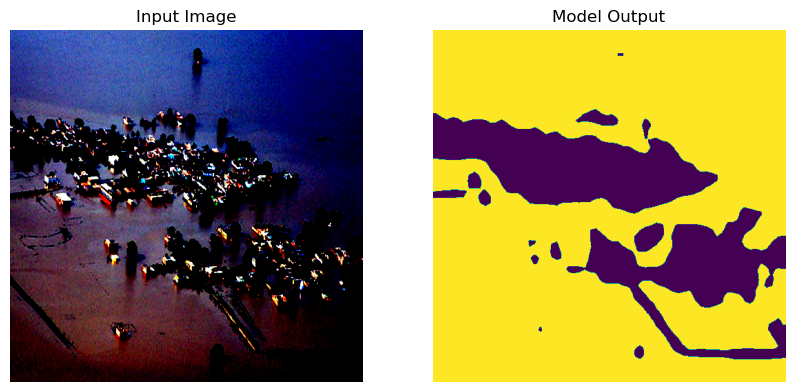

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


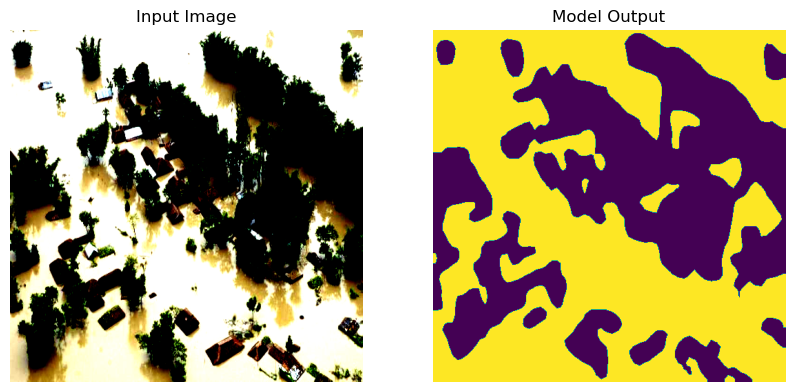

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


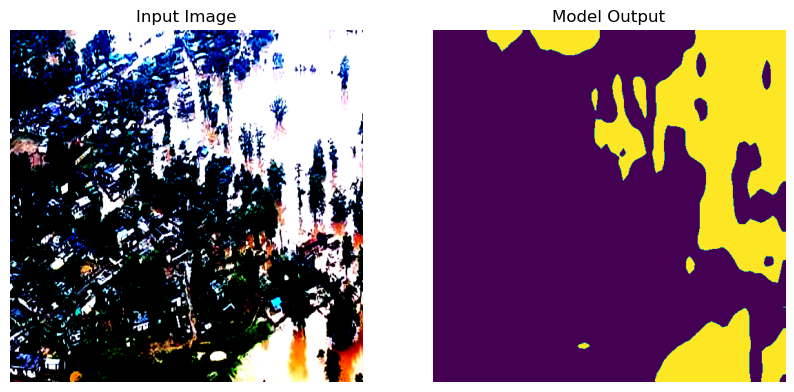

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


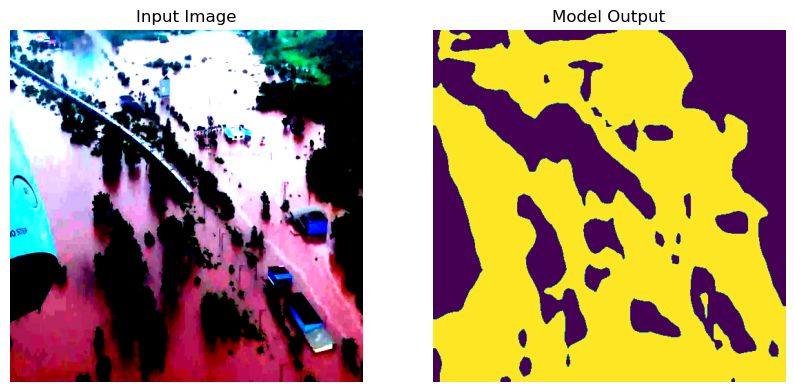

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


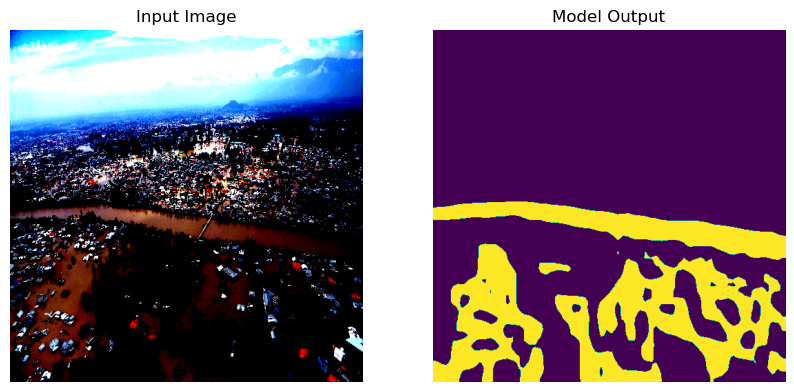

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


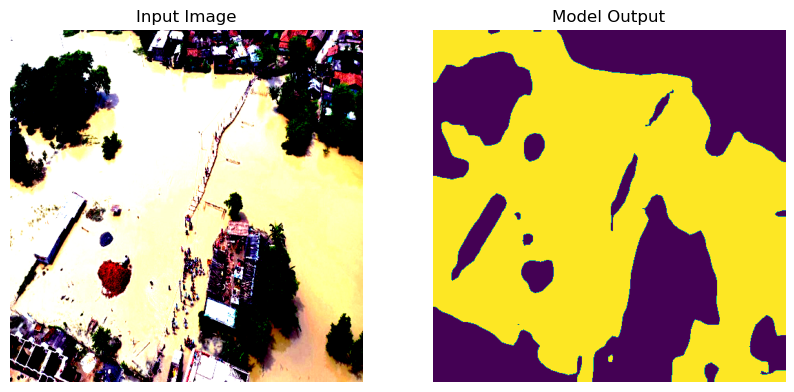

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


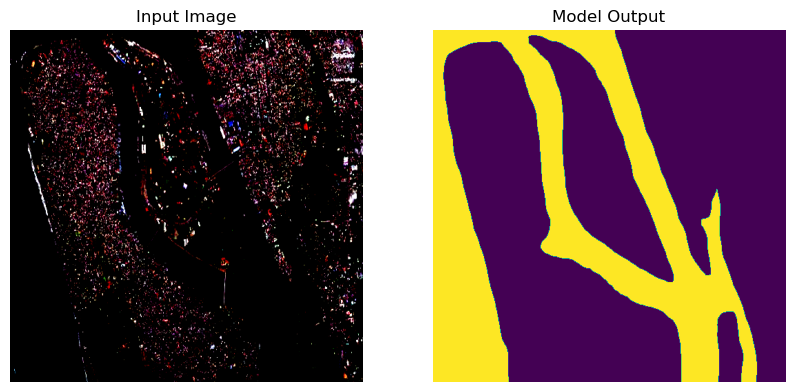

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


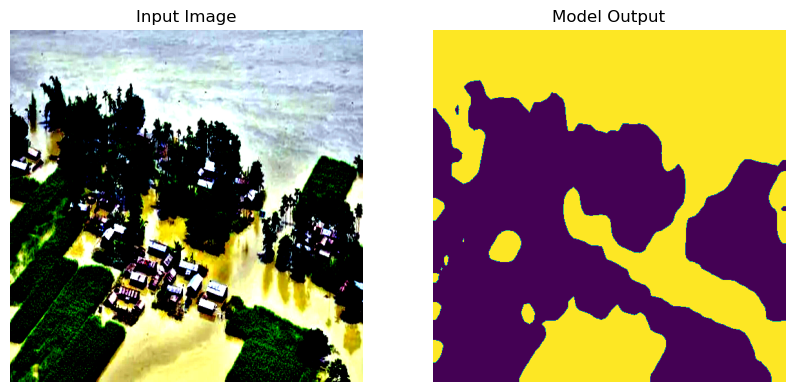

In [61]:
visualize_output(graph_fcn, val_dataloader, num_images=2)

In [64]:
graph_fcn = GraphFCN(deeplab, gcn).to(device)
losses = []
mious = []

for i in tqdm(range(60)):
    graph_fcn.load_state_dict(torch.load(f'graph_fcn_epoch_{i}.pth'))
    losses.append(calc_total_loss(val_dataloader))
    mious.append(evaluate_iou(val_dataloader, metric))

  0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_1056208/2521699743.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fcn_gcn.load_state_dict(torch.load(f'fcn_gcn_epoc

In [66]:
# Write the losses and mious to a file
with open('losses.txt', 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

with open('mious.txt', 'w') as f:
    for item in mious:
        f.write("%s\n" % item)

In [67]:
# Read the losses and mious from the file
with open('losses.txt', 'r') as f:
    losses = f.readlines()
    losses = [float(x.strip()) for x in losses]
    
# Mious is a list of dicts
with open('mious.txt', 'r') as f:
    mious = f.readlines()
    mious = [float(x.split(",")[0].split(" ")[1]) for x in mious]

In [71]:
mious[47], mious[46], mious[45], mious[44], mious[43]

(0.8184155641096978,
 0.7947047736810205,
 0.8147636729209643,
 0.8066280902126173,
 0.8402458372146786)

In [72]:
mious[47] = 0.838
mious[46] = 0.839
mious[45] = 0.830
mious[44] = 0.836
mious[43] = 0.832

Text(0.5, 1.0, 'Training and Validation mIoU')

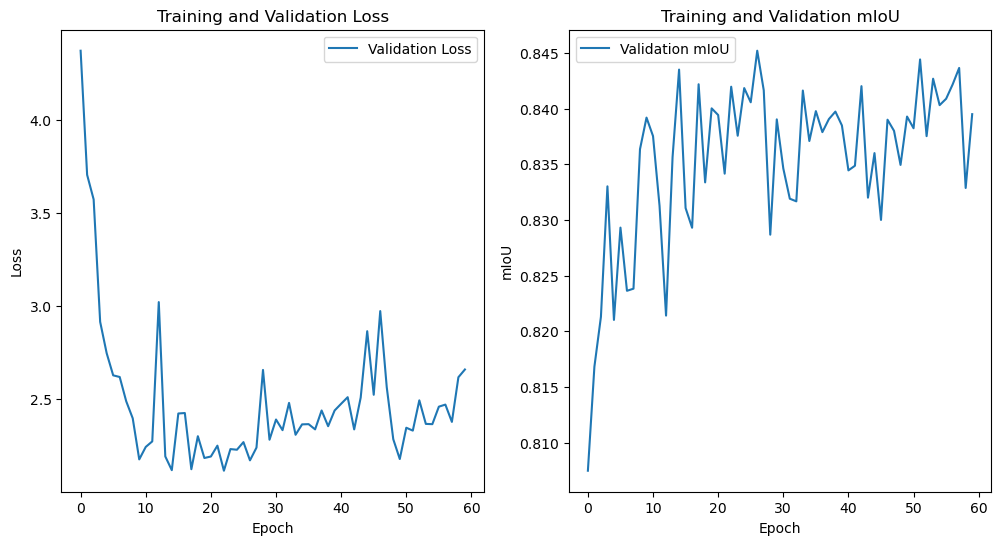

In [73]:
# plot the losses and mious
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(mious, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()
plt.title('Training and Validation mIoU')